## Instructions
**For interactive plot tool, Jupyter must be run locally (won't work if viewing via Github)**

*Hopefully*, this should be pretty straight-forward to run!

0. Install relevant python dependencies using requirements.txt (`pip3 install -r requirements.txt`). Requirements should all be pip-installable
1. Download relevant train/test set and extract. Remember locations of folders and input these locations into section in (1) **Read Data** below
2. Execute all the way up to and including 5.3 in section (5) ** Model Train** below to ensure all helper-functions are in memory, along with required global variables (such as input sizes etc.)
3. Execute section 6 - the model should be loaded provided the model files are available in the folder (as defined in 5.1). If you get a UNetwork not defined error, uncomment and execute the unet initialisation code in Section 6 or Section 5.4.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import os
import sys
import dicom
import nrrd
import scipy.ndimage
import scipy.misc
import pickle
import random
%matplotlib notebook
# Required modules

ModuleNotFoundError: No module named 'dicom'

# 1. Read Data from folders

Functionality to read and match both scans and annotations from supplied data folders and visualise 2D slices with matplotlib.

For the DCM mis-labelling bug, you need to refer to the pydicom documentation online for information on how to access the correct DCM properties (http://pydicom.readthedocs.io/en/stable/pydicom_user_guide.html#dataelement)


In [40]:
data_leader_dir = './data/leaderboard/'
anns_leader_dir = './data/leaderboard-segm/'
data_test_dir = './data/test/'
anns_test_dir = './data/test-segm/'
data_train_dir = './data/train/'
anns_train_dir = './data/train-segm/'

def return_nrrd(file_path):
    # Reads all NRRD (annotation) files within a directory
    out_nrrd = {}
    for dirName, subdirList, fileList in os.walk(file_path):
        for filename in fileList:
            if ".nrrd" in filename.lower():
                name = filename.split('_')[0] 
                name = name.split('.')[0] # Get annotation name and store in dictionary
                out_nrrd[name] = os.path.join(dirName,filename)
    return out_nrrd

def return_dcm(file_path, check_term = 'Prostate'):
    # Reads all DCM (slices) files within a directory and order the files correctly (based on filename)
    out_dcm = {}
    for dirName, subdirList, fileList in os.walk(file_path):
        c_dcm = []
        cur_name = ""
        dir_split = dirName.split("/")
        for f_chk in dir_split:
            if check_term in f_chk:
                cur_name = f_chk
        for filename in fileList:
            if ".dcm" in filename.lower():
                name = int(os.path.splitext(filename)[0])
                c_dcm.append((os.path.join(dirName,filename), name))
        if len(c_dcm) > 0:
            c_dcm = sorted(c_dcm, key = lambda t: t[1]) # Sort into correct order
            out_dcm[cur_name] = [c[0] for c in c_dcm] # Store in dictionary
    return out_dcm

def get_dataset(data_dir, anns_dir):
    # Match DCM volumes with corresponding annotation files
    data_out = []
    shapes = {}
    d_dcm = return_dcm(data_dir)
    d_nrrd = return_nrrd(anns_dir)
    for i in d_nrrd:
        seg, opts = nrrd.read(d_nrrd[i])
        voxels = np.zeros(np.shape(seg))
        for j in range(len(d_dcm[i])):
            dicom_ref = dicom.read_file(d_dcm[i][j])
            found = False
            chk_val = dicom_ref[("0020", "0013")].value 
            # Make sure you get the right slice! This is a bizarre specification thing related to DCM dataset
            # Note, if you just use the default filename ordering you get mismatched slices!
            if int(chk_val.__str__()) - 1 < np.shape(voxels)[-1]:
                voxels[:, :, int(chk_val.__str__()) - 1] = dicom_ref.pixel_array
            else: 
                print('Index: ',str(int(chk_val.__str__()) - 1), ' too large for ', i, ' skipping!')
#       Rotate and flip annotations to match volumes
        seg = scipy.ndimage.interpolation.rotate(seg, 90, reshape = False)
        for i in range(np.shape(seg)[2]):
            cur_img = np.squeeze(seg[:, :, i])
            seg[:, :, i] = np.flipud(cur_img)
        # Store volume shapes (for debug)
        if voxels.shape in shapes:
            shapes[voxels.shape] += 1
        else:
            shapes[voxels.shape] = 1
        # Saves data
        data_out.append((voxels, seg))
    return data_out

def plot_slice(slice_in, is_anns = False, num_anns = 4):
    # Plot a slice of data - can either be raw image data or corresponding annotations
    slice_in = np.squeeze(slice_in)
    plt.figure()
    plt.set_cmap(plt.bone())
    if is_anns:
        plt.pcolormesh(slice_in, vmin = 0, vmax = num_anns - 1)
    else:
        plt.pcolormesh(slice_in)
    plt.show()

##########################################################################
# Multi-slice view code extracted and adapted from: https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data

def multi_slice_viewer(feats, anns = None, preds = None, num_classes = 4):
    # Plot feats, anns, predictions in multi-slice-view
    # Note this feats OR feats + anns OR feats + anns + preds
    if anns is None:
        fig, ax = plt.subplots()
        ax.volume = feats
        ax.index = feats.shape[-1] // 2
        ax.imshow(feats[:, :, ax.index],  cmap='bone')
        fig.canvas.mpl_connect('key_press_event', process_key)
    else:
        if preds is None:
            fig, axarr = plt.subplots(1, 2)
            plt.tight_layout()
            axarr[0].volume = feats
            axarr[0].index = 0
            axarr[0].imshow(feats[:, :, axarr[0].index],  cmap='bone')
            axarr[0].set_title('Scans')
            axarr[1].volume = anns
            axarr[1].index = 0
            axarr[1].imshow(anns[:, :, axarr[1].index],  cmap='bone', vmin = 0, vmax = num_classes)
            axarr[1].set_title('Annotations')
            fig.canvas.mpl_connect('key_press_event', process_key)
        else:
            fig, axarr = plt.subplots(1, 3)
            plt.tight_layout()
            axarr[0].volume = feats
            axarr[0].index = 0
            axarr[0].imshow(feats[:, :, axarr[0].index],  cmap='bone')
            axarr[0].set_title('Scans')
            axarr[1].volume = anns
            axarr[1].index = 0
            axarr[1].imshow(anns[:, :, axarr[1].index],  cmap='bone', vmin = 0, vmax = num_classes)
            axarr[1].set_title('Annotations')
            axarr[2].volume = preds
            axarr[2].index = 0
            axarr[2].imshow(preds[:, :, axarr[2].index],  cmap='bone', vmin = 0, vmax = num_classes)
            axarr[2].set_title('Predictions')
            fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    # Process key_press events
    fig = event.canvas.figure
    if event.key == 'j':
        for ax in fig.axes: 
            previous_slice(ax)
    elif event.key == 'k':
        for ax in fig.axes: 
            next_slice(ax)            
    fig.canvas.draw()

def previous_slice(ax):
    """Go to the previous slice."""
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[-1]  # wrap around using %
    ax.images[0].set_array(volume[:, :, ax.index])

def next_slice(ax):
    """Go to the next slice."""
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[-1]
    ax.images[0].set_array(volume[:, :, ax.index])

## 1.1 Generate dataset and export

Generates dataset from provided folders and saves them to a pickle file (does not need to be performed again). 

Leader dataset is combined with train dataset (as suggested in the document repo)

In [3]:
train = get_dataset(data_train_dir, anns_train_dir)
test = get_dataset(data_test_dir, anns_test_dir)
train = train + get_dataset(data_leader_dir, anns_leader_dir)
import pickle
pickle.dump(file = open('./pickles/train.pkl', 'wb'), obj = train)
pickle.dump(file = open('./pickles/test.pkl', 'wb'), obj = test)

Index:  23  too large for  ProstateDx-01-0055  skipping!
Index:  24  too large for  ProstateDx-01-0055  skipping!
Index:  25  too large for  ProstateDx-01-0055  skipping!
Index:  26  too large for  ProstateDx-01-0055  skipping!
Index:  27  too large for  ProstateDx-01-0055  skipping!
Index:  28  too large for  ProstateDx-01-0055  skipping!
Index:  29  too large for  ProstateDx-01-0055  skipping!
Index:  30  too large for  ProstateDx-01-0055  skipping!
Index:  31  too large for  ProstateDx-01-0055  skipping!
Index:  32  too large for  ProstateDx-01-0055  skipping!
Index:  33  too large for  ProstateDx-01-0055  skipping!


## 1.2 Verify volume and annotations match for a dataset example

Verify labels are reasonable match to slices - by visualising both slices above and below each other, it is 
possible to see that they match each other well. This indicates that the features and labels are correctly 
formatted.

# When using multi-slice-viewer, press 'k' or 'j' to move forward or backward

<IPython.core.display.Javascript object>


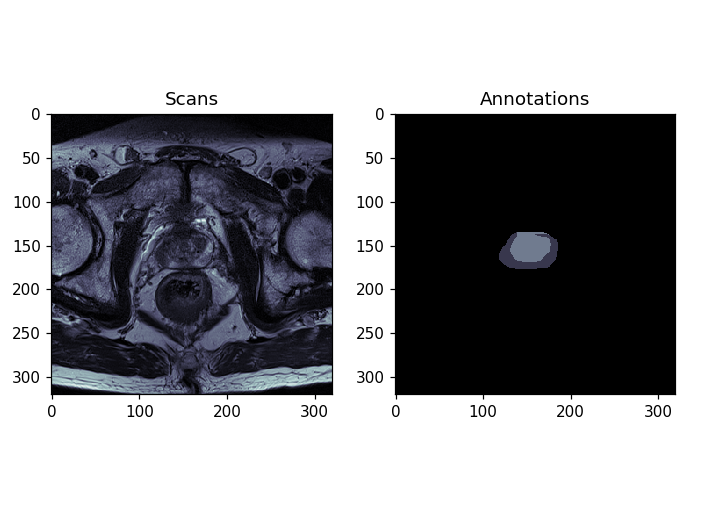

In [50]:
id_img = 12
dataset_raw = train
multi_slice_viewer(train[id_img][0], train[id_img][1])
# # OR (Old visualisation method - v.bad)
# for i in range(dataset_raw[id_img][0].shape[2]):
#     print(i)
#     plot_slice(dataset_raw[id_img][0][:, : , i], is_anns = False)
#     plot_slice(dataset_raw[id_img][1][:, : , i], is_anns = True)
# plt.close('all')

# 2. Cross-validation Dataset

### Note: cross-validation was never performed as models took too long to train. 
#### However this functionality is still here as a stub just f.y.i

Perform k-fold cross validation as per suggestions in the 3D-UNet Paper. Note, that at each training stage, this needs to be run again and the `train_raw` and `test_raw` datasets need to be regenerated.

In [3]:
do_cross_val = False # Whether to do cross-validation
if do_cross_val:
    data_total = train + test
    K_FOLD = 3
    CURRENT = 0

    val_split = len(data_total)/K_FOLD
    val_idx = CURRENT*val_split
    train = data_total[:val_idx] + data_total[val_idx+val_split:]
    test = data_total[val_idx:val_idx+val_split]
    data_total = []

# 3. Dataset Augmentation

As suggested in paper, functions to **randomly** augment dataset with *minor rotations, scale + crops and gray value augmentation*. Unfortunately, I didn't quite understand what the paper was suggesting about B-spline interpolation.

While this can easily be done in pre-processing, it can substantially increase the amount of data in memory. This is perhaps why the paper opts for this to be done on-the-fly, though this limits training speed.

In [4]:
def rotate_data(voxels, lbls, theta = None):
    # Rotates volume by a minor angle (+,- 10 degrees)
    if theta is None:
        theta = random.randint(-10, 10)
    vox_new = scipy.ndimage.interpolation.rotate(voxels, theta, reshape = False)
    lbl_new = scipy.ndimage.interpolation.rotate(lbls, theta, reshape = False)
    return vox_new, lbl_new

def scale_and_crop_centre(voxels, lbls):
    # Scales the volume by a minor size and crops around centre (can also modify for random crop)
    o_s = voxels.shape
    r_s = [0]*len(o_s)
    scale_factor = random.uniform(1, 1.2)
    vox_zoom = scipy.ndimage.interpolation.zoom(voxels, scale_factor, order = 1)
    lbl_zoom = scipy.ndimage.interpolation.zoom(lbls, scale_factor, order = 0)
    new_shape = vox_zoom.shape
    #Start with offset
    for i in range(len(o_s)):
        if new_shape[i] == 1: 
            r_s[i] = 0
            continue
        r_c = int(((new_shape[i] - o_s[i]) - 1)/2)
        r_s[i] = r_c
    r_e = [r_s[i] + o_s[i] for i in list(range(len(o_s)))]
    vox_zoom = vox_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1], r_s[2]:r_e[2]]
    lbl_zoom = lbl_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1], r_s[2]:r_e[2]]
    return vox_zoom, lbl_zoom

def grayscale(voxels, lbls):
    # Introduce a random global increment in gray-level value of volume. 
    # Gray values cannot be lower than 0
    aug = random.randint(-10, 10)
    smp = np.random.normal(0, 1, size = np.shape(voxels))
    voxels = voxels + aug*smp
    voxels[voxels <= 0] = 0
    voxels[voxels > 500] = 500 # Technically, need to cap max as well
    return voxels, lbls

def sample_with_p(p):
    # Helper function to return boolean of a sample with given probability p
    if random.random() < p:
        return True
    else:
        return False

def get_random_perturbation(voxels, lbls):
    # Generate a random perturbation of the input feature + label (and makes sure they're consistent)
    p_rotate = 0.6
    p_scale = 0.5
    p_gray = 0.6
    cur_vox, cur_lbl = voxels, lbls
    if sample_with_p(p_rotate):
        cur_vox, cur_lbl = rotate_data(cur_vox, cur_lbl)
    if sample_with_p(p_scale):
        cur_vox, cur_lbl = scale_and_crop_centre(cur_vox, cur_lbl)
    if sample_with_p(p_gray):
        cur_vox, cur_lbl = grayscale(cur_vox, cur_lbl)
    return cur_vox, cur_lbl

# 4. Data pre-processing

#### NOTE: feature INPUT and OUPUT shapes are defined here, along with DEPTH. 

Includes code to calculate Mean IOU (as defined in exercise specification document with respect to *original unscaled label*)

Generate volume + label tensors that can be passed into the Tensorflow format with the correct dimensions (and in the default `channel_last` ordering as expected by Tensorflow)

### Possible improvements: Histogram Equalisation on images 

In [5]:
INPUT_SIZE = 120 # Input feature width/height
OUTPUT_SIZE = 120 # Output feature width/height (as defined by model)
INPUT_DEPTH = 12 # Input depth 
OFF_IMAGE_FILL = 0 # What to fill an image with if padding is required to make Tensor
OFF_LABEL_FILL = 0 # What to fill a label with if padding is required to make Tensor
OUTPUT_CLASSES = 4 # Number of output classes in dataset

# Get 'natural' OUTPUT_DEPTH according to scipy method
io_zoom = OUTPUT_SIZE/INPUT_SIZE
zero_chk = np.zeros((INPUT_SIZE, INPUT_SIZE, INPUT_DEPTH))
OUTPUT_DEPTH = np.shape(scipy.ndimage.interpolation.zoom(zero_chk, io_zoom, order = 1))[-1]
# Alternatively, this can be forced to match expected tensorflow output (note, extra padding is applied if depth mismatch)
OUTPUT_DEPTH = 12 

def get_scaled_input(data, min_i = INPUT_SIZE, min_o = OUTPUT_SIZE, depth = INPUT_DEPTH, 
                    depth_out = OUTPUT_DEPTH, image_fill = OFF_IMAGE_FILL, 
                    label_fill = OFF_LABEL_FILL, n_classes = OUTPUT_CLASSES, norm_max = 500):
    
    # Takes raw data (x, y) and scales to match desired input and output sizes to feed into Tensorflow
    # Pads and normalises input and also moves axes around to orientation expected by tensorflow
    
    input_scale_factor = min_i/data[0].shape[0]
    output_scale_factor = min_o/data[0].shape[0]

    vox_zoom = None
    lbl_zoom = None

    if not input_scale_factor == 1:
        vox_zoom = scipy.ndimage.interpolation.zoom(data[0], input_scale_factor, order = 1) 
        # Order 1 is bilinear - fast and good enough
    else:
        vox_zoom = data[0]

    if not output_scale_factor == 1:
        lbl_zoom = scipy.ndimage.interpolation.zoom(data[1], output_scale_factor, order = 0) 
        # Order 0 is nearest neighbours: VERY IMPORTANT as it ensures labels are scaled properly (and stay discrete)
    else:
        lbl_zoom = data[1]   

    lbl_pad = label_fill*np.ones((min_o, min_o, depth_out - lbl_zoom.shape[-1]))
    lbl_zoom = np.concatenate((lbl_zoom, lbl_pad), 2)
    lbl_zoom = lbl_zoom[np.newaxis, :, :, :]
    
    vox_pad = image_fill*np.ones((min_i, min_i, depth - vox_zoom.shape[-1]))
    vox_zoom = np.concatenate((vox_zoom, vox_pad), 2)
    
    max_val = np.max(vox_zoom)
    if not np.max(vox_zoom) == 0:
        vox_zoom = vox_zoom * norm_max/np.max(vox_zoom)
        
    vox_zoom = vox_zoom[np.newaxis, :, :, :]

    vox_zoom = np.swapaxes(vox_zoom, 0, -1)
    lbl_zoom = np.swapaxes(lbl_zoom, 0, -1)
    # Swap axes
        
    return vox_zoom, lbl_zoom

def upscale_segmentation(lbl, shape_desired):
    # Returns scaled up label for a given input label and desired shape. Required for Mean IOU calculation
    
    scale_factor = shape_desired[0]/lbl.shape[0]
    lbl_upscale = scipy.ndimage.interpolation.zoom(lbl, scale_factor, order = 0)
    # Order 0 EVEN more important here
    lbl_upscale = lbl_upscale[:, :, :shape_desired[-1]]
    if lbl_upscale.shape[-1] < shape_desired[-1]:
        pad_zero = OFF_LABEL_FILL*np.zeros((shape_desired[0], shape_desired[1], shape_desired[2] - lbl_upscale.shape[-1]))
        lbl_upscale = np.concatenate((lbl_upscale, pad_zero), axis = -1)
    return lbl_upscale

def get_label_accuracy(pred, lbl_original):
    # Get pixel-wise labelling accuracy (DEMO metric)
    
    # Swap axes back
    pred = swap_axes(pred)
    pred_upscale = upscale_segmentation(pred, np.shape(lbl_original))
    return 100*np.sum(np.equal(pred_upscale, lbl_original))/np.prod(lbl_original.shape)

def get_mean_iou(pred, lbl_original, num_classes = OUTPUT_CLASSES, ret_full = False, reswap = False):
    # Get mean IOU between input predictions and target labels. Note, method implicitly resizes as needed
    # Ret_full - returns the full iou across all classes
    # Reswap - if lbl_original is in tensorflow format, swap it back into the format expected by plotting tools (+ format of raw data)
    
    # Swap axes back 
    pred = swap_axes(pred)
    if reswap:
        lbl_original = swap_axes(lbl_original)
    pred_upscale = upscale_segmentation(pred, np.shape(lbl_original))
    iou = [1]*num_classes
    for i in range(num_classes): 
        test_shape = np.zeros(np.shape(lbl_original))
        test_shape[pred_upscale == i] = 1
        test_shape[lbl_original == i] = 1
        full_sum = int(np.sum(test_shape))
        test_shape = -1*np.ones(np.shape(lbl_original))
        test_shape[lbl_original == i] = pred_upscale[lbl_original == i]
        t_p = int(np.sum(test_shape == i))
        if not full_sum == 0:
            iou[i] = t_p/full_sum
    if ret_full:
        return iou
    else: 
        return np.mean(iou)
    
def swap_axes(pred):
    # Swap those axes
    pred = np.swapaxes(pred, -1, 0)
    pred = np.squeeze(pred)
    return pred

## 4.1 Visualise scaled slices and test labels (and show they match original inputs)

### When using multi-slice-viewer, press 'k' or 'j' to move forward or backward

In [6]:
# id_img = 18 # Image ID to view
# dataset = train
# x, y = get_scaled_input(dataset[id_img]) # Shows that this works - can check x,y shapes if needed
# x_swap = swap_axes(x)
# y_upscale = upscale_segmentation(swap_axes(y), np.shape(swap_axes(x)))
# multi_slice_viewer(x_swap, y_upscale)  # View scaled images and labels together 

# # Compute mean iou with itself & upsampled data
# x, y = get_scaled_input(dataset[id_img])
# print('Mean iou with itself')
# print(get_mean_iou(y, y, ret_full = True, reswap = True))
# print('Mean iou with original labels')
# print(get_mean_iou(y, dataset[id_img][1], ret_full = True, reswap = False))

# 5. Training the model

In [7]:
# Load dataset data if still not done as yet
import pickle
train = pickle.load(file = open('./pickles/train.pkl', 'rb'))
test = pickle.load(file = open('./pickles/test.pkl', 'rb'))

### 5.0.1 Helper method to generate preprocessed data-augmented training sets

In [2]:
train_run = []
augment_len = 0 # Number of perturbed data-points per raw datapoint
for i in train:
    (vox, lbl) = get_scaled_input(i)
    train_run.append((vox, lbl))
    for j in range(augment_len):
        vox_a, lbl_a = get_random_perturbation(vox, lbl)
        train_run.append((vox_a, lbl_a))

NameError: name 'train' is not defined

## 5.1 Set model hyperparameters
### Also sets global model name - IMPORTANT for running model

#### To load model, pick desired folder and point `SAVE_PATH` to it. Then continue to train and/or test

In [13]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import os
import sys
import dicom
import nrrd
import scipy.ndimage
import random
%matplotlib notebook

LEARNING_RATE = 0.001 # Model learning rate
NUM_STEPS = 10000 # Number of train steps per model train
BATCH_SIZE = 3 # Batch - VRAM limited
SAVE_PATH = "./tf/" 
LOGS_PATH = "./tf_logs/"
LOAD_MODEL = True
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)
MODEL_NAME = 'model' # Model name to LOAD FROM (LOOKS IN SAVE_PATH DIRECTORY)

## 5.2 Define model 

Defined in standard tensorflow model class format

In [14]:
class UNetwork():
    
    def conv_batch_relu(self, tensor, filters, kernel = [3,3,3], stride = [1,1,1], is_training = True):
        # Produces the conv_batch_relu combination as in the paper
        padding = 'valid'
        if self.should_pad: padding = 'same'
    
        conv = tf.layers.conv3d(tensor, filters, kernel_size = kernel, strides = stride, padding = padding,
                                kernel_initializer = self.base_init, kernel_regularizer = self.reg_init)
        conv = tf.layers.batch_normalization(conv, training = is_training)
        conv = tf.nn.relu(conv) 
        return conv

    def upconvolve(self, tensor, filters, kernel = 2, stride = 2, scale = 4, activation = None):
        # Upconvolution - two different implementations: the first is as suggested in the original Unet paper and the second is a more recent version
        # Needs to be determined if these do the same thing
        padding = 'valid'
        if self.should_pad: padding = 'same'
        # upsample_routine = tf.keras.layers.UpSampling3D(size = (scale,scale,scale)) # Uses tf.resize_images
        # tensor = upsample_routine(tensor)
        # conv = tf.layers.conv3d(tensor, filters, kernel, stride, padding = 'same',
        #                                 kernel_initializer = self.base_init, kernel_regularizer = self.reg_init)
        # use_bias = False is a tensorflow bug
        conv = tf.layers.conv3d_transpose(tensor, filters, kernel_size = kernel, strides = stride, padding = padding, use_bias=False, 
                                          kernel_initializer = self.base_init,  kernel_regularizer = self.reg_init)
        return conv

    def centre_crop_and_concat(self, prev_conv, up_conv):
        # If concatenating two different sized Tensors, centre crop the first Tensor to the right size and concat
        # Needed if you don't have padding
        p_c_s = prev_conv.get_shape()
        u_c_s = up_conv.get_shape()
        offsets =  np.array([0, (p_c_s[1] - u_c_s[1]) // 2, (p_c_s[2] - u_c_s[2]) // 2, 
                             (p_c_s[3] - u_c_s[3]) // 2, 0], dtype = np.int32)
        size = np.array([-1, u_c_s[1], u_c_s[2], u_c_s[3], p_c_s[4]], np.int32)
        prev_conv_crop = tf.slice(prev_conv, offsets, size)
        up_concat = tf.concat((prev_conv_crop, up_conv), 4)
        return up_concat
        
    def __init__(self, base_filt = 8, in_depth = INPUT_DEPTH, out_depth = OUTPUT_DEPTH,
                 in_size = INPUT_SIZE, out_size = OUTPUT_SIZE, num_classes = OUTPUT_CLASSES,
                 learning_rate = LEARNING_RATE, print_shapes = True, drop = 0.2, should_pad = False):
        # Initialise your model with the parameters defined above
        # Print-shape is a debug shape printer for convenience
        # Should_pad controls whether the model has padding or not
        # Base_filt controls the number of base conv filters the model has. Note deeper analysis paths have filters that are scaled by this value
        # Drop specifies the proportion of dropped activations
        
        self.base_init = tf.truncated_normal_initializer(stddev=0.1) # Initialise weights
        self.reg_init = tf.contrib.layers.l2_regularizer(scale=0.1) # Initialise regularisation (was useful)
        
        self.should_pad = should_pad # To pad or not to pad, that is the question
        self.drop = drop # Set dropout rate
        
        with tf.variable_scope('3DuNet'):
            self.training = tf.placeholder(tf.bool)
            self.do_print = print_shapes
            self.model_input = tf.placeholder(tf.float32, shape = (None, in_depth, in_size, in_size, 1))  
            # Define placeholders for feed_dict
            self.model_labels = tf.placeholder(tf.int32, shape = (None, out_depth, out_size, out_size, 1))
            labels_one_hot = tf.squeeze(tf.one_hot(self.model_labels, num_classes, axis = -1), axis = -2)
            
            if self.do_print: 
                print('Input features shape', self.model_input.get_shape())
                print('Labels shape', labels_one_hot.get_shape())
                
            # Level zero
            conv_0_1 = self.conv_batch_relu(self.model_input, base_filt, is_training = self.training)
            conv_0_2 = self.conv_batch_relu(conv_0_1, base_filt*2, is_training = self.training)
            # Level one
            max_1_1 = tf.layers.max_pooling3d(conv_0_2, [1,2,2], [1,2,2]) # Stride, Kernel previously [2,2,2]
            conv_1_1 = self.conv_batch_relu(max_1_1, base_filt*2, is_training = self.training)
            conv_1_2 = self.conv_batch_relu(conv_1_1, base_filt*4, is_training = self.training)
            conv_1_2 = tf.layers.dropout(conv_1_2, rate = self.drop, training = self.training)
            # Level two
            max_2_1 = tf.layers.max_pooling3d(conv_1_2, [1,2,2], [1,2,2]) # Stride, Kernel previously [2,2,2]
            conv_2_1 = self.conv_batch_relu(max_2_1, base_filt*4, is_training = self.training)
            conv_2_2 = self.conv_batch_relu(conv_2_1, base_filt*8, is_training = self.training)
            conv_2_2 = tf.layers.dropout(conv_2_2, rate = self.drop, training = self.training)
            # Level three
            max_3_1 = tf.layers.max_pooling3d(conv_2_2, [1,2,2], [1,2,2]) # Stride, Kernel previously [2,2,2]
            conv_3_1 = self.conv_batch_relu(max_3_1, base_filt*8, is_training = self.training)
            conv_3_2 = self.conv_batch_relu(conv_3_1, base_filt*16, is_training = self.training)
            conv_3_2 = tf.layers.dropout(conv_3_2, rate = self.drop, training = self.training)
            # Level two
            up_conv_3_2 = self.upconvolve(conv_3_2, base_filt*16, kernel = 2, stride = [1,2,2]) # Stride previously [2,2,2] 
            concat_2_1 = self.centre_crop_and_concat(conv_2_2, up_conv_3_2)
            conv_2_3 = self.conv_batch_relu(concat_2_1, base_filt*8, is_training = self.training)
            conv_2_4 = self.conv_batch_relu(conv_2_3, base_filt*8, is_training = self.training)
            conv_2_4 = tf.layers.dropout(conv_2_4, rate = self.drop, training = self.training)
            # Level one
            up_conv_2_1 = self.upconvolve(conv_2_4, base_filt*8, kernel = 2, stride = [1,2,2]) # Stride previously [2,2,2]
            concat_1_1 = self.centre_crop_and_concat(conv_1_2, up_conv_2_1)
            conv_1_3 = self.conv_batch_relu(concat_1_1, base_filt*4, is_training = self.training)
            conv_1_4 = self.conv_batch_relu(conv_1_3, base_filt*4, is_training = self.training)
            conv_1_4 = tf.layers.dropout(conv_1_4, rate = self.drop, training = self.training)
            # Level zero
            up_conv_1_0 = self.upconvolve(conv_1_4, base_filt*4, kernel = 2, stride = [1,2,2])  # Stride previously [2,2,2]
            concat_0_1 = self.centre_crop_and_concat(conv_0_2, up_conv_1_0)
            conv_0_3 = self.conv_batch_relu(concat_0_1, base_filt*2, is_training = self.training)
            conv_0_4 = self.conv_batch_relu(conv_0_3, base_filt*2, is_training = self.training)
            conv_0_4 = tf.layers.dropout(conv_0_4, rate = self.drop, training = self.training)
            conv_out = tf.layers.conv3d(conv_0_4, OUTPUT_CLASSES, [1,1,1], [1,1,1], padding = 'same')
            self.predictions = tf.expand_dims(tf.argmax(conv_out, axis = -1), -1)
            
            # Note, this can be more easily visualised in a tool like tensorboard; Follows exact same format as in Paper.
            
            if self.do_print: 
                print('Model Convolution output shape', conv_out.get_shape())
                print('Model Argmax output shape', self.predictions.get_shape())
            
            do_weight = True
            loss_weights = [1, 150, 100, 1.0]
            # Weighted cross entropy: approach adapts following code: https://stackoverflow.com/questions/44560549/unbalanced-data-and-weighted-cross-entropy
            ce_loss = tf.nn.softmax_cross_entropy_with_logits(logits=conv_out, labels=labels_one_hot)
            if do_weight:
                weighted_loss = tf.reshape(tf.constant(loss_weights), [1, 1, 1, 1, num_classes]) # Format to the right size
                weighted_one_hot = tf.reduce_sum(weighted_loss*labels_one_hot, axis = -1)
                ce_loss = ce_loss * weighted_one_hot
            
            self.loss = tf.reduce_mean(ce_loss) # Get loss
            
            self.trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            self.extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # Ensure correct ordering for batch-norm to work
            with tf.control_dependencies(self.extra_update_ops):
                self.train_op = self.trainer.minimize(self.loss)

## 5.3 Helper functions for dataset sampling while training

In [15]:
def get_dataset_sample(data, size, no_perturb = False):
    # If augmenting on test and using original dataset, process and return augmented samples from dataset
    # NOTE: this approach is v. v. slow
    x_y_data = random.sample(data, size)
    x = []
    y = []
    orig_y = []
    for entry in x_y_data:
        x_cur, y_cur = get_random_perturbation(entry[0], entry[1])
        if no_perturb:
            x_cur, y_cur = entry
        orig_y.append(np.copy(y_cur))
        x_cur, y_cur = get_scaled_input((x_cur, y_cur))
        x.append(x_cur)
        y.append(y_cur)
    return x, y, orig_y

def get_data_raw_sample(data, size):
    # If augmentation done in pre-processing, simply sample from your data
    x_y_data = random.sample(data, size)
    return [x[0] for x in x_y_data], [y[1] for y in x_y_data]

def get_pred_iou(predictions, lbl_original, ret_full = False, reswap = False):
    # Get mean_iou for full batch
    iou = []
    for i in range(len(lbl_original)):
        pred_cur = np.squeeze(predictions[i])
        metric = get_mean_iou(pred_cur, lbl_original[i], ret_full = ret_full, reswap = reswap)
        iou.append(metric)
    if ret_full:
        return np.mean(iou, axis = 0)
    else:
        return np.mean(iou) 


## 5.4 Train model

In [38]:
tf.reset_default_graph()
unet = UNetwork(drop = 0.15, base_filt = 10, should_pad = True) # MODEL DEFINITION
init = tf.global_variables_initializer()
saver = tf.train.Saver(tf.global_variables())
config = tf.ConfigProto()
with tf.Session(config=config) as sess:
    writer = tf.summary.FileWriter(LOGS_PATH, graph=tf.get_default_graph())
    if LOAD_MODEL:
        print('Trying to load saved model...')
        try:
            print('Loading from: ', SAVE_PATH +'/'+ MODEL_NAME+ '.meta')
            restorer = tf.train.import_meta_graph(SAVE_PATH +'/'+ MODEL_NAME+ '.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(SAVE_PATH))
            print("Model sucessfully restored")
        except IOError:
            sess.run(init)
            print("No previous model found, running default init") 
    t_loss = []
    for i in range(NUM_STEPS):
        print('Current iter: ', i, end='\r')
#         x, y, orig_y = get_dataset_sample(train, BATCH_SIZE, no_perturb = True) (USED IF DATA-AUG AT RUNTIME)
        x, y = get_data_raw_sample(train_run, BATCH_SIZE) # Draw samples from batch
        train_dict = {
            unet.training: True,
            unet.model_input: x,
            unet.model_labels: y
        }
        _, loss = sess.run([unet.train_op, unet.loss], feed_dict = train_dict) # Get loss
        t_loss.append(loss) # Loss store
        if i % 400 == 0 and i > 0:
            print('Saving model at iter: ', i) # Save periodically
            saver.save(sess, SAVE_PATH + MODEL_NAME, global_step = i)
        if i % 400 == 0 and i > 0:
            print('Iteration', i, 'Loss: ', np.mean(t_loss)) # Get periodic progress reports
            t_loss = []
            iou_size = 5
#             x, y, orig_y = get_dataset_sample(train, iou_size) (USED IF DATA-AUG AT RUNTIME)
            x, y = get_data_raw_sample(train_run, BATCH_SIZE) 
            train_dict = {
                unet.training: False,
                unet.model_input: x,
                unet.model_labels: y
            }
            preds = np.squeeze(sess.run([unet.predictions], feed_dict = train_dict))
            iou = get_pred_iou(preds, y, ret_full = True, reswap = True)
            print('Train IOU (on SCALED anns): ', iou, 'Mean: ', np.mean(iou[:OUTPUT_CLASSES-1]))
            # Get test mean IOU over batch
            x, y, orig_y = get_dataset_sample(test, iou_size, no_perturb = True)            
            train_dict = {
                unet.training: False,
                unet.model_input: x,
                unet.model_labels: y
            }
            preds = np.squeeze(sess.run([unet.predictions], feed_dict = train_dict))
            iou = get_pred_iou(preds, orig_y, ret_full = True)
            print('Test IOU (on ORIGINAL anns): ', iou, 'Mean: ', np.mean(iou[:OUTPUT_CLASSES-1]))
            print('######################')
  
    saver.save(sess,SAVE_PATH + MODEL_NAME, global_step = NUM_STEPS) # Final save

Input features shape (?, 12, 120, 120, 1)
Labels shape (?, 12, 120, 120, 4)
Model Convolution output shape (?, 12, 120, 120, 4)
Model Argmax output shape (?, 12, 120, 120, 1)


# 6. Model Inference

#### Important:
If 5.4 has not been executed, then uncomment top line and just run this code.  Otherwise comment top line and run (Tensorflow reuse-scope issue)

In [39]:
# unet = UNetwork(drop = 0.15, base_filt = 10, should_pad = True) # MODEL DEFINITION
# UNET MODEL IS DEFINED IN TRAIN STEP - beware of reusing twice (if variables already initialised, comment above line and rerun)

test = pickle.load(file = open('./pickles/test.pkl', 'rb'))
TEST_MODEL_NAME = MODEL_NAME # Just for consistency - can ofc. be changed

config = tf.ConfigProto()
test_predictions = []
with tf.Session(config=config) as sess:
    print('Loading saved model ...')
#   try
    restorer = tf.train.import_meta_graph(SAVE_PATH +'/'+ TEST_MODEL_NAME + '.meta')
    restorer.restore(sess, tf.train.latest_checkpoint(SAVE_PATH))
    print("Model sucessfully restored")
    pred_out = []
    y_orig = []
    x_orig = []
    x_in = []
    y_in = []
    i = 0
    iou_out = []

    while i < len(test):
        x_batch = []
        y_batch = []
        for j in range(i, min(len(test), i + BATCH_SIZE)):
            y_orig.append(np.copy(test[j][1]))
            x_orig.append(np.copy(test[j][0]))
            x_cur, y_cur = get_scaled_input(test[j])
            x_batch.append(x_cur)
            y_batch.append(y_cur)
        if len(x_batch) == 0: break
        print('Processing ', i)
        x_in = x_in + x_batch
        y_in = y_in + y_batch
        test_dict = {
            unet.training: False, # Whether to perform batch-norm at inference (Paper says this would be useful)
            unet.model_input: x_batch,
            unet.model_labels: y_batch
        }
        test_predictions = np.squeeze(sess.run([unet.predictions], feed_dict = test_dict))
        if len(x_batch) == 1:
            pred_out.append(test_predictions)
        else:
            pred_out.extend([np.squeeze(test_predictions[z, :, :, :]) for z in list(range(len(x_batch)))])
        i += BATCH_SIZE

    for i in range(len(y_orig)):
        iou = get_mean_iou(pred_out[i], y_orig[i], ret_full = True)
        print('Test IOU: ', iou, 'Mean: ', np.mean(iou[:OUTPUT_CLASSES-1]))
        iou_out.append(np.mean(iou[:OUTPUT_CLASSES-1]))

    print('Mean test IOU', np.mean(iou_out), 'Var IOU', np.var(iou_out))
#     except Exception as e:
#         print('Something went wrong!', e)


Loading saved model ...
INFO:tensorflow:Restoring parameters from ./tf/model
Model sucessfully restored
Processing  0
Processing  3
Processing  6
Processing  9
Test IOU:  [0.9816001419141939, 0.030535211267605635, 0.1901139443011525, 1] Mean:  0.4007497658276507
Test IOU:  [0.984749512253417, 0.07645706361081712, 0.09268447311116625, 1] Mean:  0.3846303496584668
Test IOU:  [0.985014799245409, 0.05940210656753408, 0.14826708826362986, 1] Mean:  0.3975613313588577
Test IOU:  [0.9834626108719173, 0.023913559393017186, 0.16652373134694076, 1] Mean:  0.3912999672039584
Test IOU:  [0.9765779642043505, 0.024715930328175227, 0.15323965028544054, 1] Mean:  0.3848445149393221
Test IOU:  [0.9874176107915543, 0.10021747009786154, 0.3583405637724732, 1] Mean:  0.48199188155396305
Test IOU:  [0.9857577561697948, 0.13972676721206545, 0.5189093358313527, 1] Mean:  0.5481312864044043
Test IOU:  [0.9678747580194577, 0.05123982066062769, 0.2925213260229768, 1] Mean:  0.43721196823435404
Test IOU:  [0.986

## 6.1 Visualise output

#### Change what is displayed by simply changing id_img below. id_img should be a value from 0-9 
#### Look at output IOUs from above to see which test subjects are the best ones to visualise

### 6.1.1 Example 'good' prediction

#### Model works well-ish but seems to overstate size of prostrate. That being said, in some situations (like in the default image below), the segmentation seems to find the outline of the prostrate more effectively than the default annotation.

Press 'j' or 'k' to cycle through the plots in depth

<IPython.core.display.Javascript object>


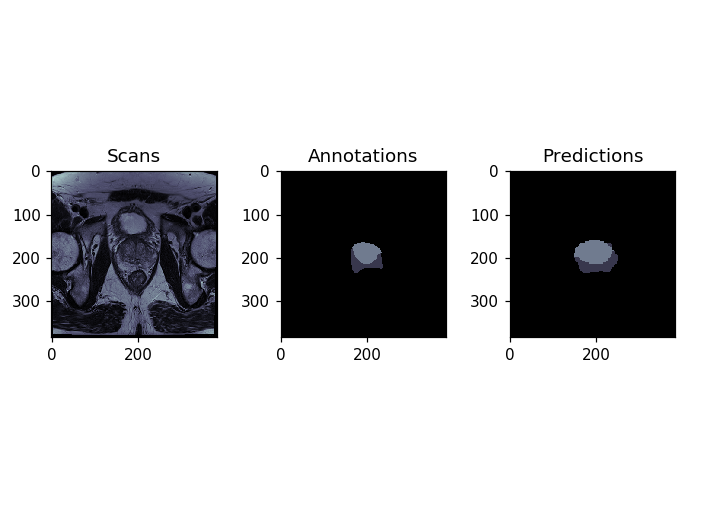

In [36]:
id_img = -1
x_cur = x_orig[id_img]
y_cur = y_orig[id_img]
y_upscale = upscale_segmentation(swap_axes(pred_out[id_img][:, :, :, np.newaxis]), np.shape(x_cur))
multi_slice_viewer(x_cur, y_cur, y_upscale) # View  images, labels and predictions together 

### 6.1.2 Example 'bad' prediction

#### Dark images seem to consistently perform badly - perhaps the data needs some form of Histogram Equalisation during the preprocessing stage

Note: on this test-set, there are very few 'very bad' failure cases - what tends to happen is that the model seems to overstate the size of the segmentation, for the most part. This may be due to a lack of proper training or perhaps due to the label upscaling process

Press 'j' or 'k' to cycle through the plots in depth

<IPython.core.display.Javascript object>


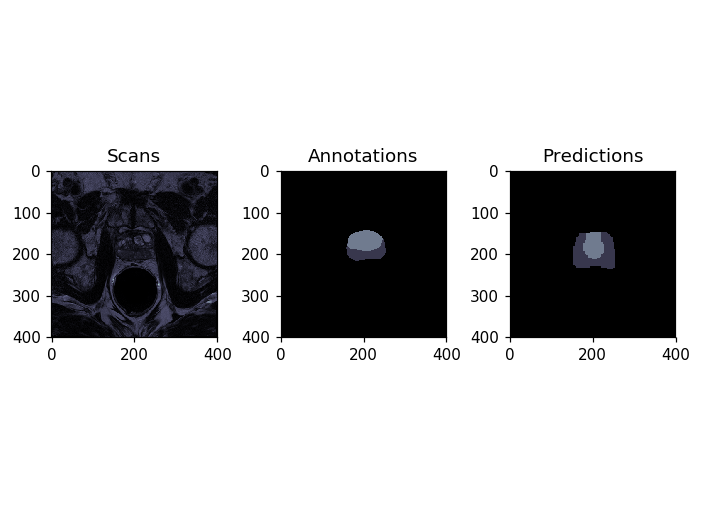

In [35]:
id_img = 1
x_cur = x_orig[id_img]
y_cur = y_orig[id_img]
y_upscale = upscale_segmentation(swap_axes(pred_out[id_img][:, :, :, np.newaxis]), np.shape(x_cur))
multi_slice_viewer(x_cur, y_cur, y_upscale) # View  images, labels and predictions together 